In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tfrecorder import TFrecorder
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


# data

In [2]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


# how to write

In [3]:
# info of data
df = pd.DataFrame({'name':['image','label'],
                  'type':['float32','int64'],
                  'shape':[(784,),()],
                  'isbyte':[False,False],
                  "length_type":['fixed','fixed'],
                  "default":[np.NaN,np.NaN]})

In [4]:
df

,default,isbyte,length_type,name,shape,type
0,NaN,False,fixed,image,"(784,)",float32
1,NaN,False,fixed,label,(),int64


# write

In [5]:
tfr = TFrecorder()

In [6]:
mkdir mnist_tfrecord mnist_tfrecord/train mnist_tfrecord/test

In [7]:
dataset = mnist.train
path = 'mnist_tfrecord/train/train'
num_examples_per_file = 1000
num_so_far = 0

writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
# write mutilple examples
for i in np.arange(dataset.num_examples):
    features = {}
    # write image of one example
    tfr.feature_writer(df.iloc[0], dataset.images[i], features)
    # write label of one example
    tfr.feature_writer(df.iloc[1], dataset.labels[i], features)
    
    tf_features = tf.train.Features(feature= features)
    tf_example = tf.train.Example(features = tf_features)
    tf_serialized = tf_example.SerializeToString()
    writer.write(tf_serialized)
    if i%num_examples_per_file ==0 and i!=0:
        writer.close()
        num_so_far = i
        writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
        print('saved %s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
writer.close()

saved mnist_tfrecord/train/train1000_2000.tfrecord
saved mnist_tfrecord/train/train2000_3000.tfrecord
saved mnist_tfrecord/train/train3000_4000.tfrecord
saved mnist_tfrecord/train/train4000_5000.tfrecord
saved mnist_tfrecord/train/train5000_6000.tfrecord
saved mnist_tfrecord/train/train6000_7000.tfrecord
saved mnist_tfrecord/train/train7000_8000.tfrecord
saved mnist_tfrecord/train/train8000_9000.tfrecord
saved mnist_tfrecord/train/train9000_10000.tfrecord
saved mnist_tfrecord/train/train10000_11000.tfrecord
saved mnist_tfrecord/train/train11000_12000.tfrecord
saved mnist_tfrecord/train/train12000_13000.tfrecord
saved mnist_tfrecord/train/train13000_14000.tfrecord
saved mnist_tfrecord/train/train14000_15000.tfrecord
saved mnist_tfrecord/train/train15000_16000.tfrecord
saved mnist_tfrecord/train/train16000_17000.tfrecord
saved mnist_tfrecord/train/train17000_18000.tfrecord
saved mnist_tfrecord/train/train18000_19000.tfrecord
saved mnist_tfrecord/train/train19000_20000.tfrecord
saved mnis

In [8]:
dataset = mnist.test
path = 'mnist_tfrecord/test/test'
num_examples_per_file = 1000
num_so_far = 0

writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
# write mutilple examples
for i in np.arange(dataset.num_examples):
    features = {}
    # write image of one example
    tfr.feature_writer(df.iloc[0], dataset.images[i], features)
    # write label of one example
    tfr.feature_writer(df.iloc[1], dataset.labels[i], features)
    
    tf_features = tf.train.Features(feature= features)
    tf_example = tf.train.Example(features = tf_features)
    tf_serialized = tf_example.SerializeToString()
    writer.write(tf_serialized)
    if i%num_examples_per_file ==0 and i!=0:
        writer.close()
        num_so_far = i
        writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
        print('saved %s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
writer.close()
data_info_path = 'mnist_tfrecord/data_info.csv'
df.to_csv(data_info_path,index=False)

saved mnist_tfrecord/test/test1000_2000.tfrecord
saved mnist_tfrecord/test/test2000_3000.tfrecord
saved mnist_tfrecord/test/test3000_4000.tfrecord
saved mnist_tfrecord/test/test4000_5000.tfrecord
saved mnist_tfrecord/test/test5000_6000.tfrecord
saved mnist_tfrecord/test/test6000_7000.tfrecord
saved mnist_tfrecord/test/test7000_8000.tfrecord
saved mnist_tfrecord/test/test8000_9000.tfrecord
saved mnist_tfrecord/test/test9000_10000.tfrecord


# import function

In [9]:
tfr = TFrecorder()
def input_fn_maker(path, data_info_path, shuffle=False, batch_size = 1, epoch = 1, padding = None):
    def input_fn():
        filenames = tfr.get_filenames(path=path, shuffle=shuffle)
        dataset=tfr.get_dataset(paths=filenames, data_info=data_info_path, shuffle = shuffle, 
                            batch_size = batch_size, epoch = epoch, padding =padding)
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
    return input_fn

In [10]:
padding_info = ({'image':[784,],'label':[]})
test_input_fn = input_fn_maker('mnist_tfrecord/test/',  'mnist_tfrecord/data_info.csv',
                               padding = padding_info)
train_input_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', shuffle=True, batch_size = 512,
                               padding = padding_info)
train_eval_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', batch_size = 512,
                               padding = padding_info)
test_inputs = test_input_fn()

read dataframe from mnist_tfrecord/test/test1000_2000.tfrecord x 10


(1, 784)


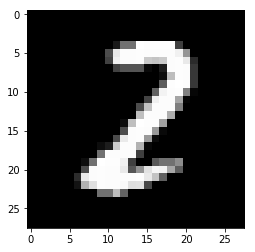

In [11]:
sess =tf.InteractiveSession()
print(test_inputs['image'].eval().shape)
plt.imshow(test_inputs['image'].eval().reshape((28,28)),cmap=plt.cm.gray)